<a href="https://colab.research.google.com/github/satyajitghana/stable-diffusion-from-scratch/blob/master/notebooks/ViT_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! wget -O cat.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSKr5wT7rfkjkGvNeqgXjBmarC5ZNoZs-H2uMpML8O7Q4F9W-IlUQibBT6IPqyvX45NOgw&usqp=CAU

--2023-01-29 13:34:19--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSKr5wT7rfkjkGvNeqgXjBmarC5ZNoZs-H2uMpML8O7Q4F9W-IlUQibBT6IPqyvX45NOgw
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 142.251.12.101, 142.251.12.139, 142.251.12.113, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|142.251.12.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6107 (6.0K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]   5.96K  --.-KB/s    in 0s      

2023-01-29 13:34:19 (76.4 MB/s) - ‘cat.jpg’ saved [6107/6107]



In [2]:
! pip install --quiet einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.9 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import itertools

import torch.nn as nn

from PIL import Image
import torchvision.transforms as T
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [4]:
img = Image.open("cat.jpg")

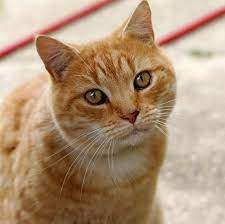

In [5]:
img

In [6]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

In [7]:
x = transforms(img)
x = x[None, ...]
x.shape

torch.Size([1, 3, 224, 224])

## Patch Embedding

In [8]:
patch_size = 16
patches = rearrange(
    x,
    'b c (h s1) (w s2) -> b (h w) (s1 s2 c)',
    s1=patch_size,
    s2=patch_size
)

In [9]:
patches.shape

torch.Size([1, 196, 768])

In [10]:
patches_d = rearrange(
    x,
    'b c (h s1) (w s2) -> b h w s1 s2 c',
    s1 = 16,
    s2 = 16
)
patches_d.shape

torch.Size([1, 14, 14, 16, 16, 3])

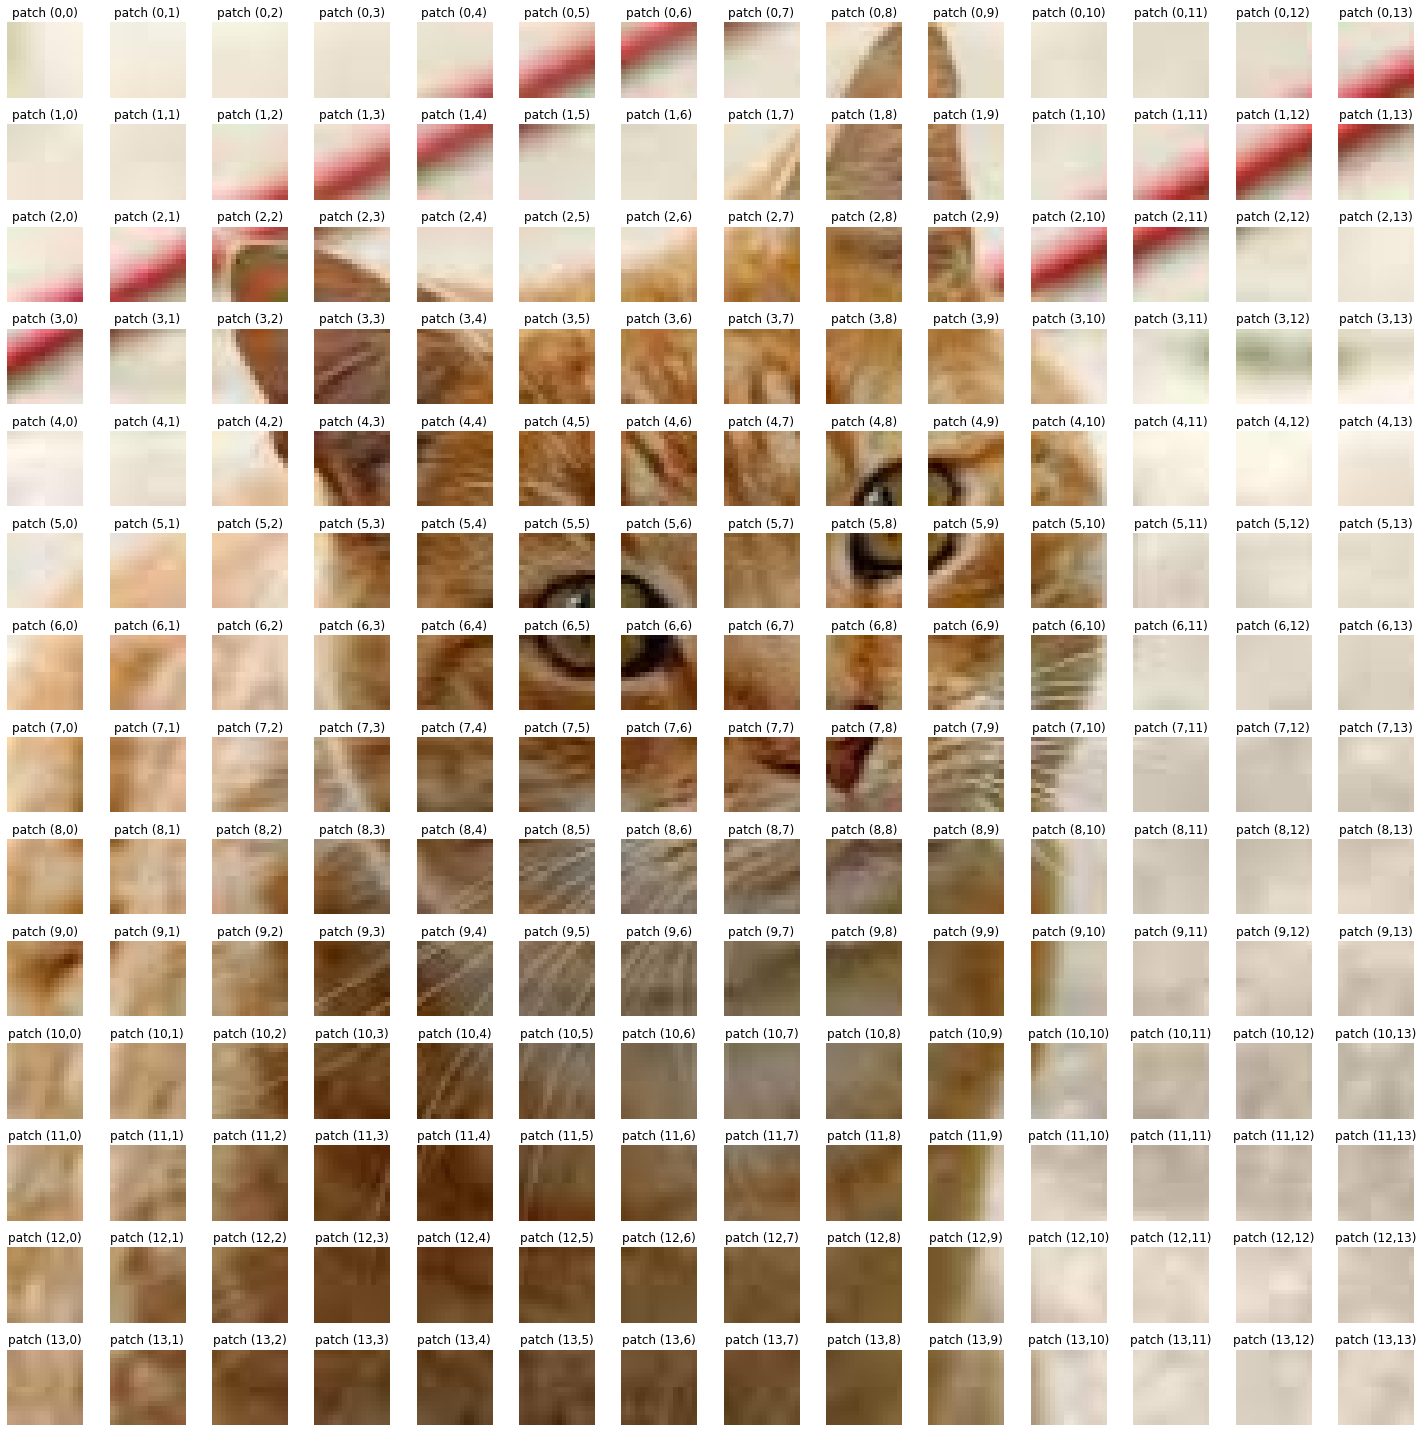

In [11]:
fig, axes = plt.subplots(nrows=14, ncols=14, figsize=(20, 20))
for i, j in itertools.product(range(14), repeat=2):
    axes[i, j].imshow(patches_d[0, i, j])
    axes[i, j].axis('off')
    axes[i, j].set_title(f"patch ({i},{j})")
fig.tight_layout()
plt.show()

In [12]:
class PatchEmbedding(nn.Module):
    def __init__(
        self, in_channels = 3, patch_size = 16, emb_size = 768
    ):
        super(PatchEmbedding, self).__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x):
        x = self.projection(x)

        return x

In [13]:
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

`CLS` Token

think of this like, one patch is dedicated to `CLS` token, `16*16*3` in shape

In [14]:
torch.randn(1, 1, 768).shape

torch.Size([1, 1, 768])

Positions

Each of the patch is going to have a position, also the cls token patch.

In [15]:
torch.randn((224 // 16) * (224 // 16) + 1, 786).shape

torch.Size([197, 786])

In [50]:
class PatchEmbedding(nn.Module):
    def __init__(
        self, in_channels = 3, patch_size = 16, emb_size = 768, img_size = 224,
    ):
        super(PatchEmbedding, self).__init__()

        assert img_size / patch_size % 1 == 0, "img_size must be integer multiple of patch_size"

        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

        self.cls_token = nn.Parameter(
            torch.randn(1, 1, emb_size)
        )

        self.positional_emb = nn.Parameter(
            torch.randn(
                (img_size // patch_size) * (img_size // patch_size) + 1, # 14 x 14 patches + CLS patch
                emb_size
            )
        )

    def forward(self, x):
        B, *_ = x.shape 
        x = self.projection(x)
        # print(x.shape, )
        cls_token = repeat(self.cls_token, '() p e -> b p e', b = B)

        # print(cls_token.shape)

        x = torch.cat([cls_token, x], dim=1)

        x += self.positional_emb

        return x

In [17]:
patch_embedding = PatchEmbedding()(x)
patch_embedding.shape

torch.Size([1, 197, 768])

## MultiHeadAttention

In [18]:
keys = nn.Linear(768, 768)
queries = nn.Linear(768, 768)
values = nn.Linear(768, 768)

projection = nn.Linear(768, 768)

In [19]:
energy = torch.matmul(queries(patch_embedding), keys(patch_embedding).permute(0, 2, 1))
energy.shape

torch.Size([1, 197, 197])

In [20]:
attention = F.softmax(energy, dim=-1)
attention.shape

torch.Size([1, 197, 197])

In [21]:
torch.sum(attention[0, 0, :])

tensor(1., grad_fn=<SumBackward0>)

In [22]:
attention.shape, values(patch_embedding).shape

(torch.Size([1, 197, 197]), torch.Size([1, 197, 768]))

In [23]:
out = torch.matmul(attention, values(patch_embedding))

out.shape

torch.Size([1, 197, 768])

In [24]:
projection(out).shape

torch.Size([1, 197, 768])

In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(
        self,
        emb_size = 768,
        num_heads = 8,
        dropout = 0
    ):
        super(MultiHeadAttention, self).__init__()

        self.num_heads = num_heads
        self.emb_size = emb_size

        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)

        self.projection = nn.Linear(emb_size, emb_size)

        self.attn_dropout = nn.Dropout(dropout)

        self.scaling = (self.emb_size // num_heads) ** -0.5

    def forward(self, x, mask = None):
        rearrange_heads = 'batch seq_len (num_head h_dim) -> batch num_head seq_len h_dim'

        queries = rearrange(
            self.query(x),
            rearrange_heads,
            num_head = self.num_heads
        )
        keys = rearrange(
            self.key(x),
            rearrange_heads,
            num_head = self.num_heads
        )

        values = rearrange(
            self.key(x),
            rearrange_heads,
            num_head = self.num_heads
        )

        energies = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)

        if mask is not None:
            fill_value = torch.finfo(energies.dtype).min
            energies.mask_fill(~mask, fill_value)

        attention = F.softmax(energies, dim=-1) * self.scaling

        attention = self.attn_dropout(attention)

        out = torch.einsum('bhas, bhsd -> bhad', attention, values)

        out = rearrange(out, 'batch num_head seq_length dim -> batch seq_length (num_head dim)')

        out = self.projection(out)

        return out


In [26]:
MultiHeadAttention()(patch_embedding).shape

torch.Size([1, 197, 768])

In [27]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super(ResidualAdd, self).__init__()

        self.fn = fn

    def forward(self, x, **kwargs):
        res = x

        out = self.fn(x, **kwargs)

        out += res

        return out

In [28]:
FeedForwardBlock = lambda emb_size = 768, expansion = 4, drop_p = 0.: nn.Sequential(
    nn.Linear(emb_size, expansion * emb_size),
    nn.GELU(),
    nn.Dropout(drop_p),
    nn.Linear(expansion * emb_size, emb_size)
)

## TransformerEncoderBlock

In [29]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(
        self,
        emb_size = 768,
        drop_p = 0.,
        forward_expansion = 4,
        forward_drop_p = 0,
        **kwargs
    ):
        super(TransformerEncoderBlock, self).__init__(
            ResidualAdd(
                nn.Sequential(
                    nn.LayerNorm(emb_size),
                    MultiHeadAttention(emb_size, **kwargs),
                    nn.Dropout(drop_p)
                )
            ),
            ResidualAdd(
                nn.Sequential(
                    nn.LayerNorm(emb_size),
                    FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                    nn.Dropout(drop_p)
                )
            )
        )

In [30]:
TransformerEncoderBlock()(patch_embedding).shape

torch.Size([1, 197, 768])

In [31]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth = 12, **kwargs):
        super(TransformerEncoder, self).__init__(
            *(TransformerEncoderBlock(**kwargs) for _ in range(depth))
        )

In [32]:
trans_out = TransformerEncoder()(patch_embedding)
trans_out.shape

torch.Size([1, 197, 768])

## Classification Head

In [33]:
class ClassificationHead(nn.Sequential):
    def __init__(
        self,
        emb_size = 768,
        num_classes = 1000
    ):
        super(
            ClassificationHead,
            self
        ).__init__(
            Reduce(
                'batch_size seq_len emb_dim -> batch_size emb_dim',
                reduction='mean'
            ),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes)
        )

In [34]:
ClassificationHead()(trans_out).shape

torch.Size([1, 1000])

## ViT

In [35]:
class ViT(nn.Sequential):
    def __init__(
        self,
        in_channels = 3,
        patch_size = 16,
        emb_size = 768,
        img_size = 224,
        depth = 12,
        num_classes = 1000,
        **kwargs
    ):
        super(ViT, self).__init__(
            PatchEmbedding(
                in_channels, patch_size, emb_size, img_size,
            ),
            TransformerEncoder(
                depth, emb_size=emb_size, **kwargs
            ),
            ClassificationHead(
                emb_size, num_classes
            )
        )

In [36]:
ViT()(x).shape

torch.Size([1, 1000])

In [38]:
summary(
    ViT(),
    input_size=(3, 224, 224),
    device="cpu"
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 196, 768]               0
            Linear-2             [-1, 196, 768]         590,592
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
MultiHeadAttention-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
      ResidualAdd-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 1

## CIFAR10

In [39]:
! pip install --quiet pytorch-lightning==1.7.7 torchmetrics==0.11.0 lightning-bolts==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.1/708.1 KB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 KB 34.8 MB/s eta 0:00:00


In [43]:
from pl_bolts.datamodules import CIFAR10DataModule
from torch.optim.lr_scheduler import OneCycleLR
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization

import pytorch_lightning as pl

from torchmetrics.functional import accuracy

In [110]:
config = {
    "data_dir": ".",
    "batch_size": 256,
    "num_workers": 2,
    "num_classes": 10,
    "lr": 1e-4,
    "max_lr": 1e-3,
}

In [111]:
train_transforms = T.Compose(
    [
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        cifar10_normalization(),
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=config["data_dir"],
    batch_size=config["batch_size"],
    num_workers=config["num_workers"],
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
)

In [112]:
ViT(
    in_channels=3,
    patch_size=4,
    emb_size=128,
    img_size=32,
    depth=12,
    num_classes=10
)

ViT(
  (0): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=4, s2=4)
      (1): Linear(in_features=48, out_features=128, bias=True)
    )
  )
  (1): TransformerEncoder(
    (0): TransformerEncoderBlock(
      (0): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
            (projection): Linear(in_features=128, out_features=128, bias=True)
            (attn_dropout): Dropout(p=0, inplace=False)
          )
          (2): Dropout(p=0.0, inplace=False)
        )
      )
      (1): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (1): Sequential(
   

In [113]:
ViT(
    in_channels=3,
    patch_size=4,
    emb_size=128,
    img_size=32,
    depth=12,
    num_classes=10
)(torch.randn(1, 3, 32, 32))

tensor([[ 0.4556, -0.0425, -0.1020, -0.0155, -0.4003,  0.8658,  0.5972,  0.4019,
          0.0239,  0.2900]], grad_fn=<AddmmBackward0>)

In [118]:
class LitViT(pl.LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = ViT(
            in_channels=3,
            patch_size=4,
            emb_size=128,
            img_size=32,
            depth=12,
            num_classes=10
        )

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=config["num_classes"])

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
        )
        steps_per_epoch = 45_000 // config["batch_size"]
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                max_lr=config["max_lr"],
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [119]:
model = LitViT(
    lr=config["lr"]
)

In [120]:
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="auto",
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [124]:
trainer.fit(model, cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /content/lightning_logs/version_10/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | ViT  | 2.4 M 
-------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.582     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [123]:
trainer.test(model, datamodule=cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7627999782562256
        test_loss           0.6916049718856812
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6916049718856812, 'test_acc': 0.7627999782562256}]